In [23]:
import torch
import numpy
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_size = 0.8
val_size = 0.2
generator = torch.Generator().manual_seed(42)

In [3]:
def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:normalization(tensor, 0, 1))
])

def add_noise(img_tensor, std=0.35):
    return (img_tensor + torch.randn(img_tensor.size(), generator=generator) * std)

In [4]:
train_data  = torchvision.datasets.MNIST("./data", train=True, transform=img_transform, download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=img_transform, download=False)

data_size = len(train_data)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

In [7]:
len(train_set), len(val_set)

(48000, 12000)

cpu


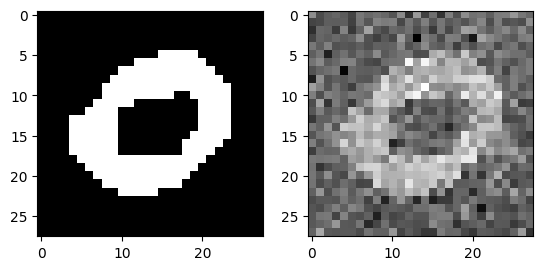

In [8]:
fig, ax = plt.subplots(1, 2)
j = 69
x, _ = train_set[j]
print(x.device)
ax[0].imshow(x.numpy()[0], cmap='gray')
ax[1].imshow(add_noise(x).numpy()[0], cmap='gray')

In [45]:
x.shape

torch.Size([1, 28, 28])

In [79]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
# 1 input image channel, 6 output channels,
#5x5 square convolution
# kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
# an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        print(x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        print(x.shape)
        x = torch.flatten(x)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.relu(self.fc2(x))
        print(x.shape)
        x = self.fc3(x)
        print(x.shape)

        return x

In [80]:
m = Net()

m(x)

torch.Size([1, 28, 28])
torch.Size([6, 12, 12])
torch.Size([16, 4, 4])
torch.Size([256])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x256 and 400x120)

In [52]:
class ConvAE(nn.Module):
    def __init__(self, input_dim:int = 784, hidden_dim:int = 512, latent_dim:int = 64, kernel_size:int = 5):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 6, kernel_size=kernel_size),
                                     nn.GELU(), 
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(6, 16, kernel_size=kernel_size),
                                     nn.GELU(),
                                     nn.MaxPool2d(2),
                                     nn.Flatten(),
                                     nn.Linear(16 * kernel_size * kernel_size, latent_dim),
                                     nn.GELU()
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(64, 256),
                                     nn.GELU(), 
                                     nn.Linear(256, input_dim),
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        
        return x

In [53]:
m = ConvAE()

m(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x16 and 400x64)

In [ ]:
class AE(nn.Module):
    def __init__(self, input_dim:int = 784, hidden_dim:int = 512, latent_dim:int = 64):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(input_dim, 256),
                                     nn.GELU(), 
                                     nn.Linear(256, latent_dim),
                                     nn.GELU())
        
        self.decoder = nn.Sequential(nn.Linear(64, 256),
                                     nn.GELU(), 
                                     nn.Linear(256, input_dim),
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        
        return self.decoder(x)

epoch [1/51], tr_loss: 0.1944, val_loss: 0.1903
epoch [2/51], tr_loss: 0.1513, val_loss: 0.1447
epoch [3/51], tr_loss: 0.1283, val_loss: 0.1191
epoch [4/51], tr_loss: 0.1152, val_loss: 0.1034
epoch [5/51], tr_loss: 0.1063, val_loss: 0.0934
epoch [6/51], tr_loss: 0.1000, val_loss: 0.0880
epoch [7/51], tr_loss: 0.1726, val_loss: 0.1663
epoch [8/51], tr_loss: 0.1271, val_loss: 0.1160
epoch [9/51], tr_loss: 0.1088, val_loss: 0.1009
epoch [10/51], tr_loss: 0.1058, val_loss: 0.0941
epoch [11/51], tr_loss: 0.0992, val_loss: 0.0899
epoch [12/51], tr_loss: 0.0999, val_loss: 0.0880
epoch [13/51], tr_loss: 0.0959, val_loss: 0.0856
epoch [14/51], tr_loss: 0.0954, val_loss: 0.0841
epoch [15/51], tr_loss: 0.0934, val_loss: 0.0833
epoch [16/51], tr_loss: 0.0928, val_loss: 0.0813
epoch [17/51], tr_loss: 0.0930, val_loss: 0.0806
epoch [18/51], tr_loss: 0.0900, val_loss: 0.0792
epoch [19/51], tr_loss: 0.0928, val_loss: 0.0781
epoch [20/51], tr_loss: 0.0918, val_loss: 0.0776
epoch [21/51], tr_loss: 0.090

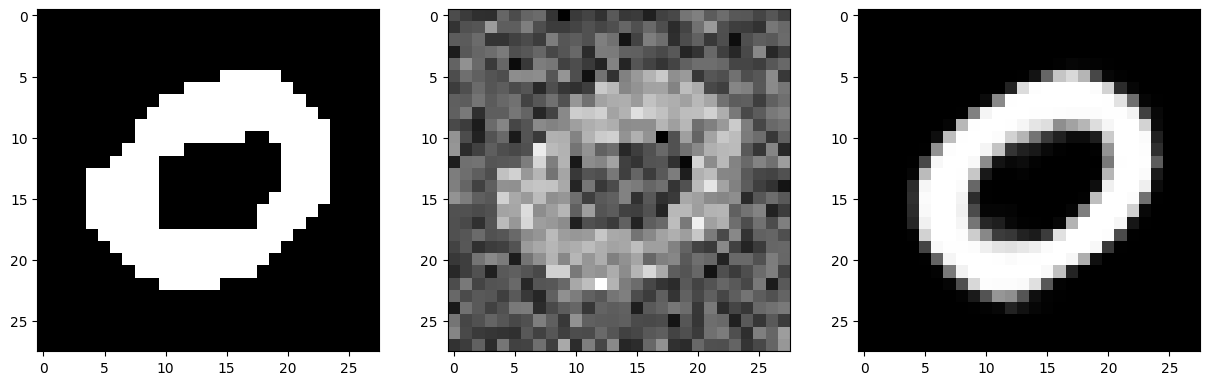

In [44]:
j = 69
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
x, _ = train_set[j]
x_noisy = add_noise(x)

model = AE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-6)
criterion = torch.nn.BCELoss()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, pin_memory=True)

epochs = 51
for epoch in range(epochs):
    model.train()
    for input_img, _ in train_loader:
        optimizer.zero_grad()
        
        img_noisy = add_noise(input_img).to(device)
        out = model(img_noisy)
        
        input_img = input_img.to(device)
        tr_loss = criterion(out, input_img.view(input_img.size(0), -1))

        tr_loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for j, (input_img, _) in enumerate(val_loader):
            input_img = input_img.to(device)
            out = model(input_img)
                
            val_loss = criterion(out, input_img.view(input_img.size(0), -1))

        print(f"epoch [{epoch + 1}/{epochs}], tr_loss: {tr_loss.item():.4f}, val_loss: {val_loss.item():.4f}")
        
        if (epoch % 10 == 0):
            ax[0].imshow(x.numpy()[0], cmap='gray')
            ax[1].imshow(x_noisy.numpy()[0], cmap='gray')
            out = model(x_noisy.to(device))
            ax[2].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')